# TIME SERIES PREDICTION 

## Problem Statement

Unicorn Investors wants to make an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! The investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file.

### Hypothesis Generation 

1. Traffic will increase as the years pass by
2. Traffic will be high from May to October
3. Traffic on weekdays will be more
4. Traffic during the peak hours will be high

Getting the system ready

In [122]:
import pandas as pd          
import numpy as np          # For mathematical calculations 
import matplotlib.pyplot as plt  # For plotting graphs 
from datetime import datetime    # To access datetime 
from pandas import Series        # To work on series 
from statsmodels.tsa.stattools import adfuller 
%matplotlib inline 
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")

Loading train and test data

In [123]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Making copy of training and test data

train_original = train.copy()
test_original = test.copy()

### Exploring the datasets

Dataset structure and content

In [124]:
train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [125]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object, ID           int64
 Datetime    object
 dtype: object)

Shape of the dataset

In [126]:
train.shape, test.shape

((18288, 3), (5112, 2))

In [127]:
train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


As we can see that the data type of Datetime is object hence we have to change its data type to datetime format otherwise we cannot extract features from it

In [128]:
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')
test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M')

We made some hypothesis for the effect of hour, day, month and year on the passenger count. So, let’s extract the year, month, day and hour from the Datetime to validate our hypothesis.

In [129]:
for i in (train, test, train_original, test_original):
    i['year'] = i.Datetime.dt.year
    i['month'] = i.Datetime.dt.month
    i['day'] = i.Datetime.dt.day
    i['hour'] = i.Datetime.dt.hour

We made a hypothesis for the traffic pattern on weekday and weekend as well. So, let’s make a weekend variable to visualize the impact of weekend on traffic.
We will first extract the day of week from Datetime and then based on the values we will assign whether the day is a weekend or not.
Values of 5 and 6 represents that the days are weekend.

In [130]:
train['day_of_week'] = train['Datetime'].dt.dayofweek 

Function to assign day as weekend or not

In [131]:
def applyer(row) :
    if row.dayofweek==5 or row.dayofweek==6 :
        return 1
    else : 
        return 0

In [132]:
temp = train['Datetime'].apply(applyer)
train['weekend'] = temp

Let's look at the time series

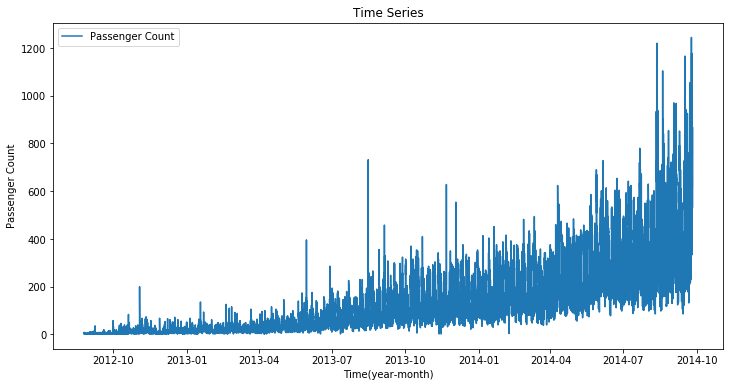

In [133]:
train.index = train['Datetime']    #indexing the Datetime to get time period on the x-axis
df = train.drop('ID',1)
ts = df['Count']
plt.figure(figsize=(12,6))
plt.plot(ts, label='Passenger Count')
plt.title('Time Series')
plt.xlabel('Time(year-month)')
plt.ylabel('Passenger Count')
plt.legend(loc='best')

warnings.filterwarnings('ignore')

### Exploratory Analysis 

Yearly passenger count

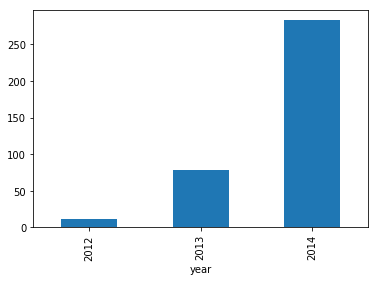

In [134]:
train.groupby('year')['Count'].mean().plot.bar()

Monthly passenger count

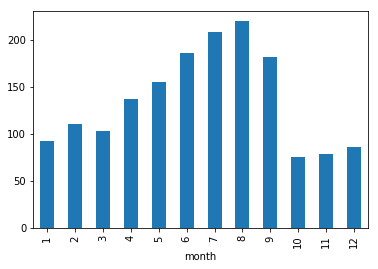

In [135]:
train.groupby('month')['Count'].mean().plot.bar()

Here we see a decrease in the mean of passenger count in last three months. This does not look right. Let’s look at the monthly mean of each year separately.

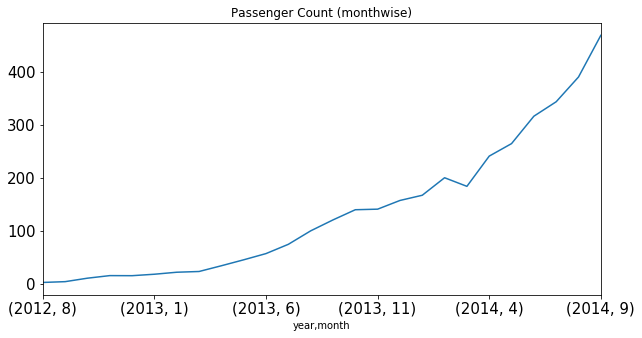

In [136]:
temp = train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize=(10,5), title='Passenger Count (monthwise)', fontsize=15)

Daily mean of Passenger Count

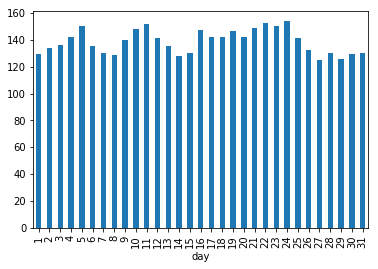

In [137]:
train.groupby('day')['Count'].mean().plot.bar()

Hourly passenger count

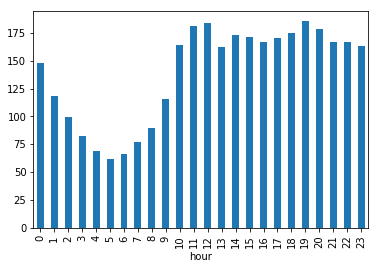

In [138]:
train.groupby('hour')['Count'].mean().plot.bar()

Weekday passenger count

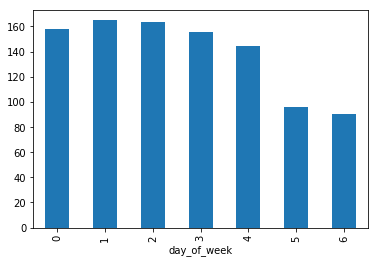

In [139]:
train.groupby('day_of_week')['Count'].mean().plot.bar()

As we have seen that there is a lot of noise in the hourly time series, we will aggregate the hourly time series to daily, weekly, and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.

In [140]:
train = train.drop('ID',1)
train.Timestamp = pd.to_datetime(train.Datetime, format='%d-%m-%y %H:%M')
train.index = train.Timestamp 

In [141]:
## Hourly time series
hourly = train.resample('H').mean()
## Daily time series
daily = train.resample('D').mean()
## Weekly time series
weekly = train.resample('W').mean()
## Monthly time series
monthly = train.resample('M').mean()

Let’s look at the hourly, daily, weekly and monthly time series.

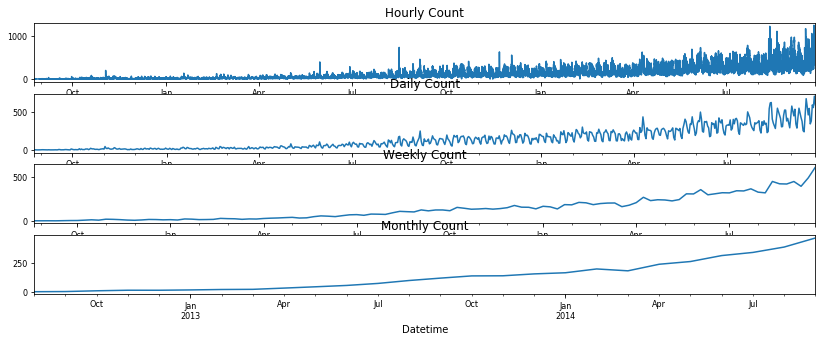

In [142]:
fig, axs = plt.subplots(4,1)
hourly.Count.plot(figsize=(14,5), title='Hourly Count', fontsize=8, ax=axs[0])
daily.Count.plot(figsize=(14,5), title='Daily Count', fontsize=8, ax=axs[1])
weekly.Count.plot(figsize=(14,5), title='Weekly Count', fontsize=8, ax=axs[2])
monthly.Count.plot(figsize=(14,5), title='Monthly Count', fontsize=8, ax=axs[3])

plt.show()

We can see that the time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis.

But it would be difficult to convert the monthly and weekly predictions to hourly predictions, as first we have to convert the monthly predictions to weekly, weekly to daily and daily to hourly predictions, which will become very expanded process. So, we will work on the daily time series.

In [143]:
train.Timestamp = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
train.index = train.Timestamp  
test.Timestamp = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
test.index = test.Timestamp  

## Converting to daily mean
train = train.resample('D').mean()
test = test.resample('D').mean()

### Splitting the data into training and validation part 

In [144]:
train.index

DatetimeIndex(['2012-08-25', '2012-08-26', '2012-08-27', '2012-08-28',
               '2012-08-29', '2012-08-30', '2012-08-31', '2012-09-01',
               '2012-09-02', '2012-09-03',
               ...
               '2014-09-16', '2014-09-17', '2014-09-18', '2014-09-19',
               '2014-09-20', '2014-09-21', '2014-09-22', '2014-09-23',
               '2014-09-24', '2014-09-25'],
              dtype='datetime64[ns]', name='Datetime', length=762, freq='D')

The starting date of the dataset is 25-08-2012 as we have seen in the exploration part and the end date is 25-09-2014.

In [145]:
Train = train.ix['2012-08-25' : '2014-06-24']
valid = train.ix['2014-06-25' : '2014-09-25']

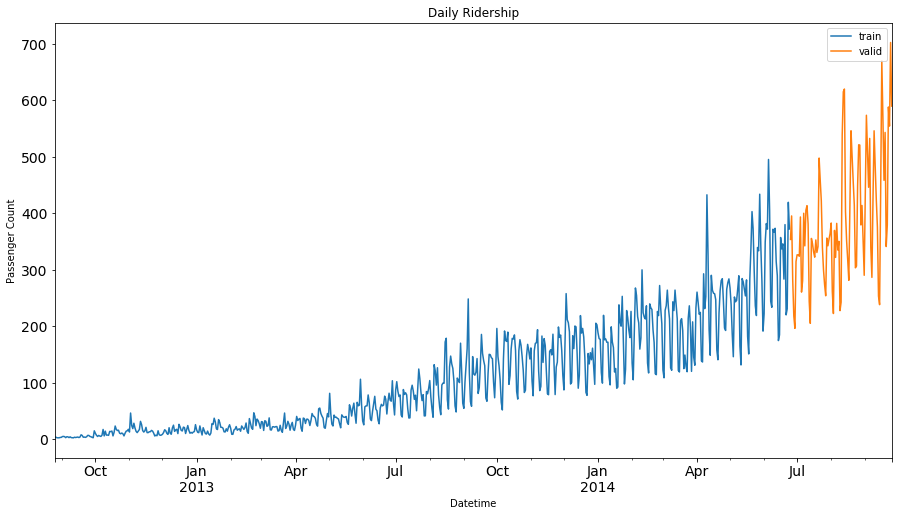

In [146]:
Train.Count.plot(figsize=(15,8), title="Daily Ridership", fontsize=14, label="train")
valid.Count.plot(figsize=(15,8), title="Daily Ridership", fontsize=14, label="valid")
plt.xlabel("Datetime")
plt.ylabel("Passenger Count")
plt.legend(loc="best")
plt.show()

### Stationarity Checking of the Time Series 

For original training set

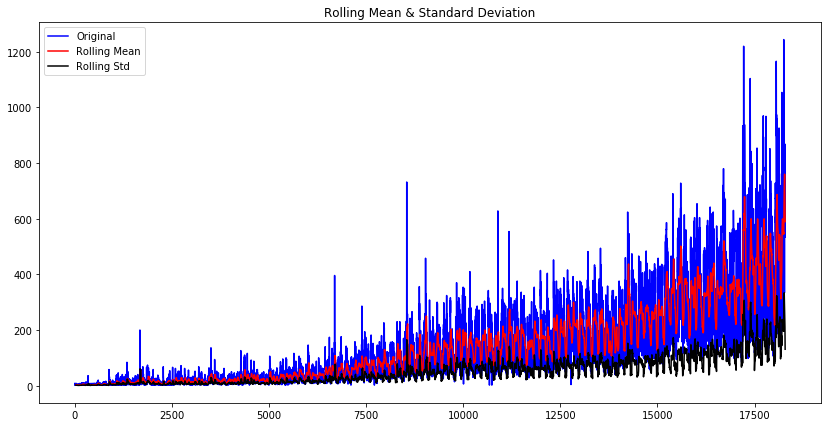

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [147]:

def test_stationarity(timeseries):
        #Determing rolling statistics
    # rolmean = pd.rolling_mean(timeseries, window=24) # 24 hours on each day
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()
        #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 14,7
test_stationarity(train_original['Count'])

Test Statistics is lesser than the Critical Values hance it is a stationary time series

For current train dataset

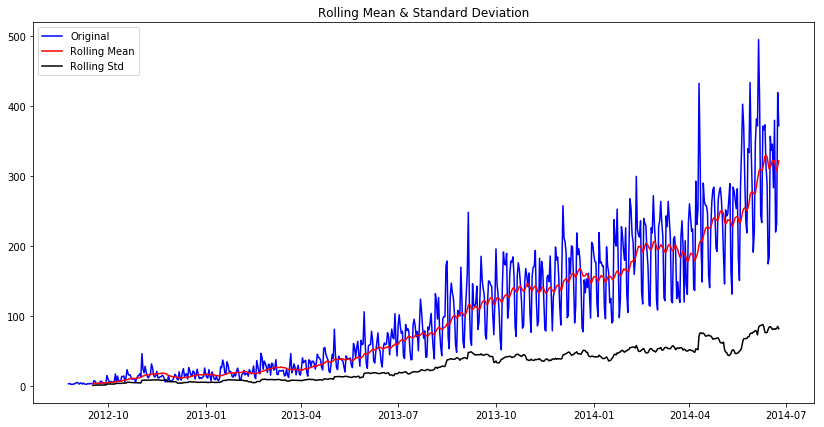

Results of Dickey-Fuller Test:
Test Statistic                   1.387308
p-value                          0.997056
#Lags Used                      20.000000
Number of Observations Used    648.000000
Critical Value (1%)             -3.440482
Critical Value (5%)             -2.866011
Critical Value (10%)            -2.569151
dtype: float64


In [148]:
rcParams['figure.figsize'] = 14,7
test_stationarity(Train['Count'])

Non-stationary Time Series since Test Statistics is greater than Critical Values

### Removing Trend

In [149]:
train_log = np.log(Train['Count'])
valid_log = np.log(valid['Count'])

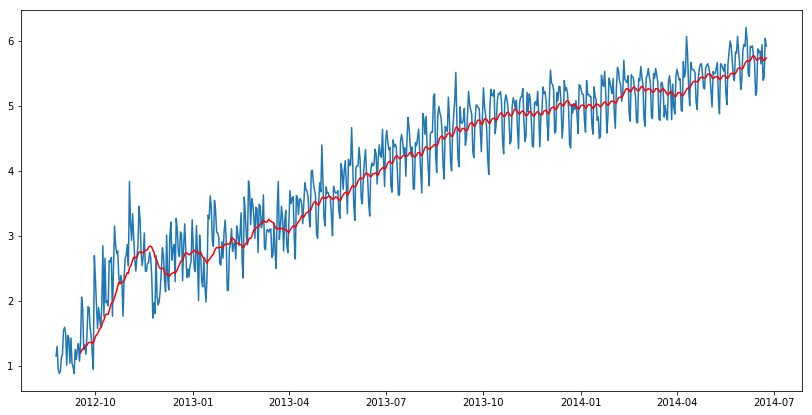

In [150]:
moving_avg = train_log.rolling(24).mean()
plt.plot(train_log)
plt.plot(moving_avg, color='red')
plt.show()

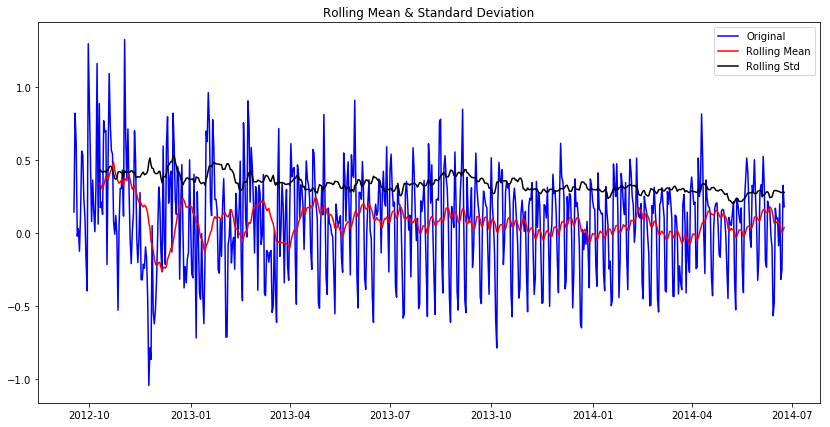

Results of Dickey-Fuller Test:
Test Statistic                -5.861646e+00
p-value                        3.399422e-07
#Lags Used                     2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [151]:
train_log_moving_avg_diff = train_log - moving_avg
train_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(train_log_moving_avg_diff)

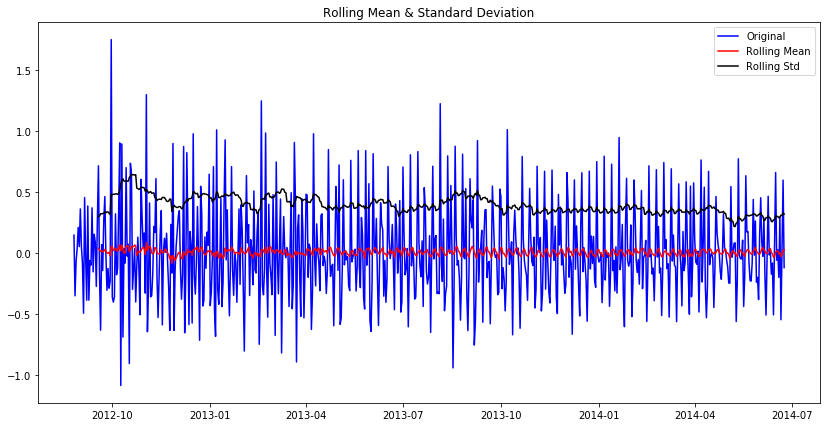

Results of Dickey-Fuller Test:
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [152]:
## train_log_diff = train_log_moving_avg_diff - train_log_moving_avg_diff.shift(1)
train_log_diff = train_log - train_log.shift(1)
test_stationarity(train_log_diff.dropna())

### Removing Seasonality

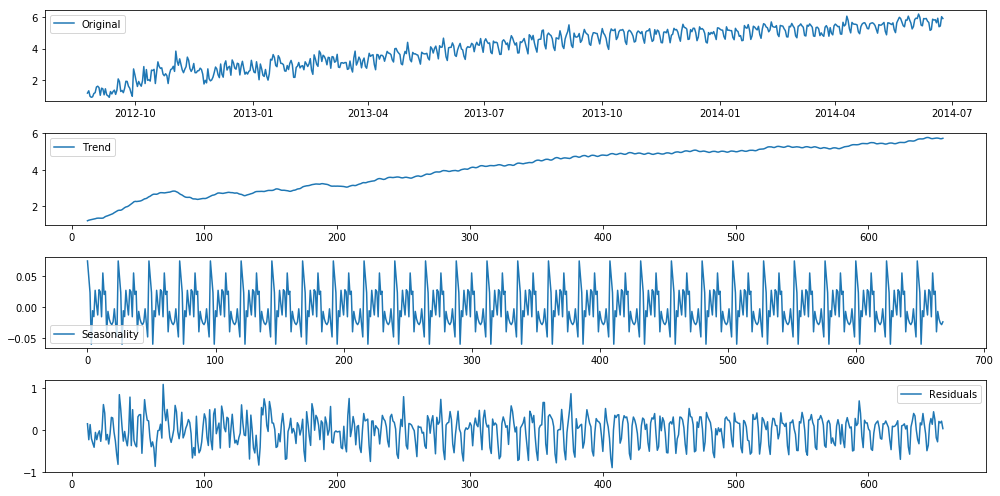

In [153]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(pd.DataFrame(train_log).Count.values, freq = 24) 

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 

plt.subplot(411) 
plt.plot(train_log, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Residuals') 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show()

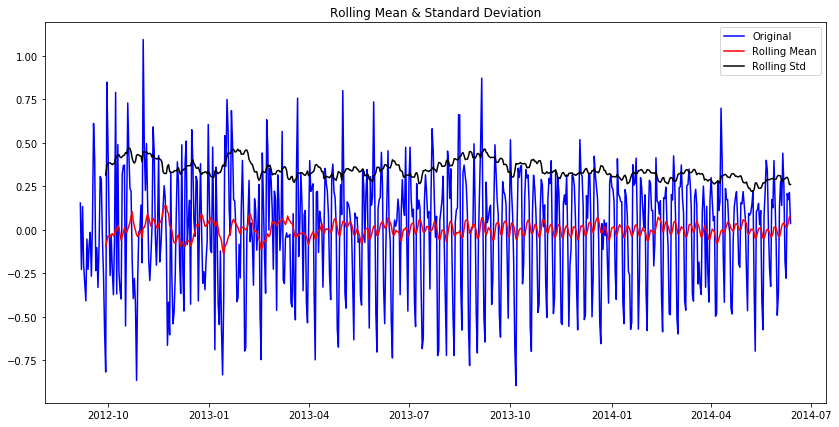

Results of Dickey-Fuller Test:
Test Statistic                -7.822096e+00
p-value                        6.628321e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [154]:
train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = train_log.index 
train_log_decompose.set_index('date', inplace = True) 
train_log_decompose.dropna(inplace=True) 
test_stationarity(train_log_decompose[0])

## Forecasting the Time Series Using ARIMA 

In [155]:
from statsmodels.tsa.stattools import acf, pacf 
lag_acf = acf(train_log_diff.dropna(), nlags=25) 
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

### ACF and PACF plots

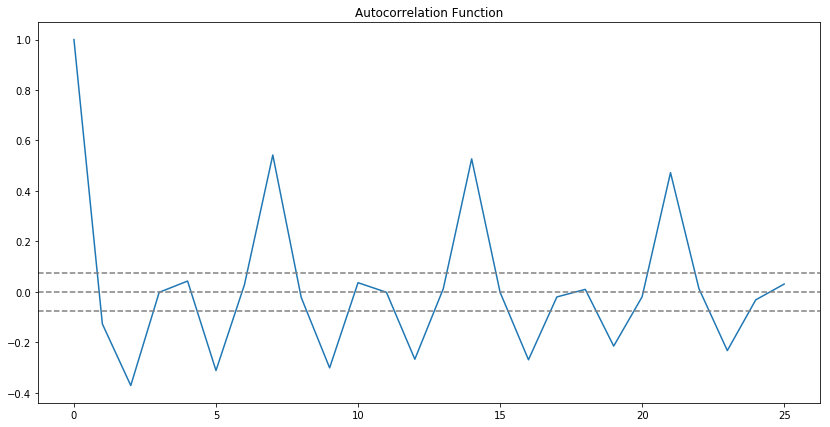

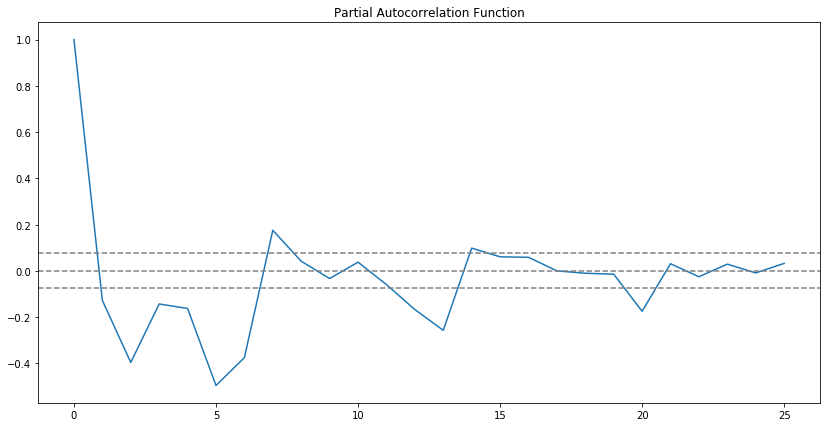

In [156]:
plt.plot(lag_acf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Autocorrelation Function') 
plt.show() 
plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.show()

Functions to scale the series back to original form and calculate RMSE

In [157]:
 def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)

    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
 
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

### AR Model

In [158]:
train_log_diff=train_log_diff.dropna()

In [200]:
train_log_diff.head()

Datetime
2012-08-26    0.146603
2012-08-27   -0.350202
2012-08-28   -0.066691
2012-08-29    0.033902
2012-08-30    0.209721
Freq: D, Name: Count, dtype: float64

In [268]:
test.head()

,ID,year,month,day,hour
Datetime,,,,,
2014-09-26,18299.5,2014.0,9.0,26.0,11.5
2014-09-27,18323.5,2014.0,9.0,27.0,11.5
2014-09-28,18347.5,2014.0,9.0,28.0,11.5
2014-09-29,18371.5,2014.0,9.0,29.0,11.5
2014-09-30,18395.5,2014.0,9.0,30.0,11.5


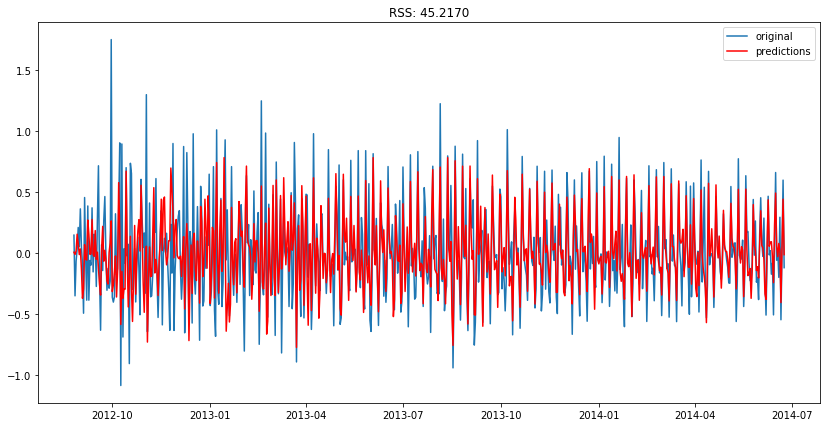

In [160]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_log, order=(14, 1, 0))  # here the q value is zero since it is just the AR model 
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_AR.fittedvalues, color='red', label='predictions') 
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-train_log_diff)**2))
plt.legend(loc='best') 
plt.show()

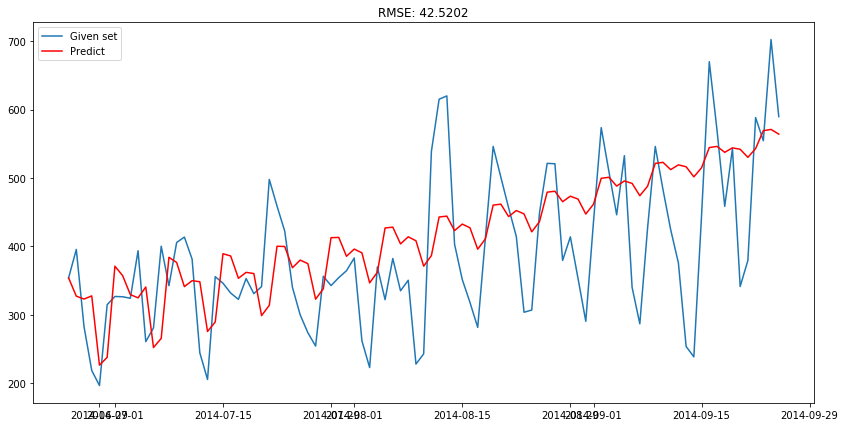

In [207]:
AR_predict=results_AR.predict(start="2014-06-25", end="2014-09-25") 
check_prediction_diff(AR_predict, valid)

### MA Model

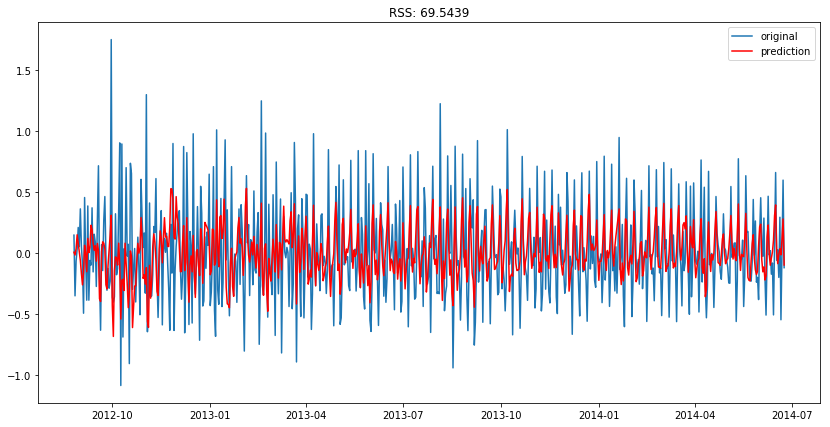

In [162]:
model = ARIMA(train_log, order=(0, 1, 2))  # here the p value is zero since it is just the MA model 
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_MA.fittedvalues, color='red', label='prediction') 
plt.legend(loc='best') 
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-train_log_diff)**2))
plt.show()

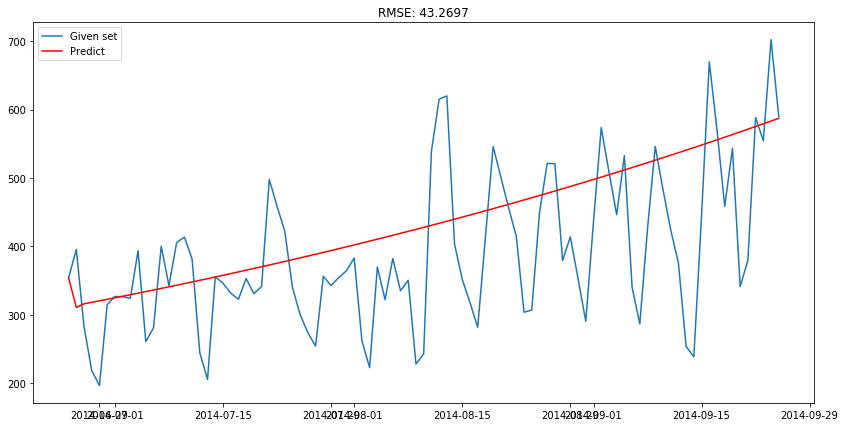

In [163]:
MA_predict=results_MA.predict(start="2014-06-25", end="2014-09-25") 
check_prediction_diff(MA_predict, valid)

### Combined Model 

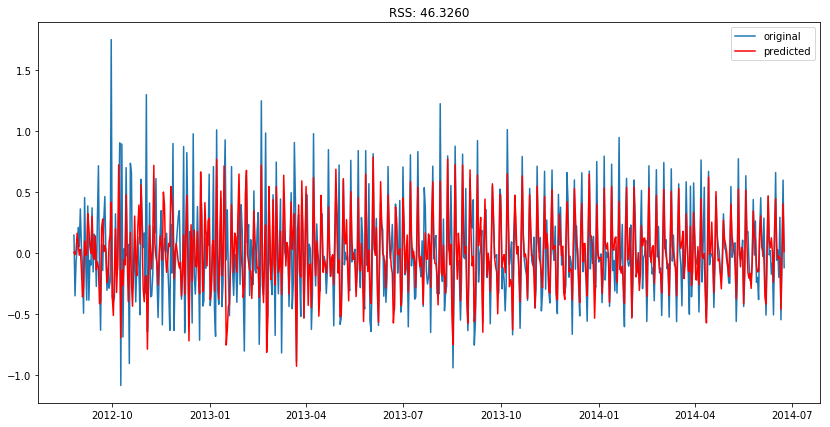

In [164]:
model = ARIMA(train_log.dropna(), order=(10, 1, 3))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original') 
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted') 
plt.legend(loc='best') 
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-train_log_diff)**2))
plt.show()

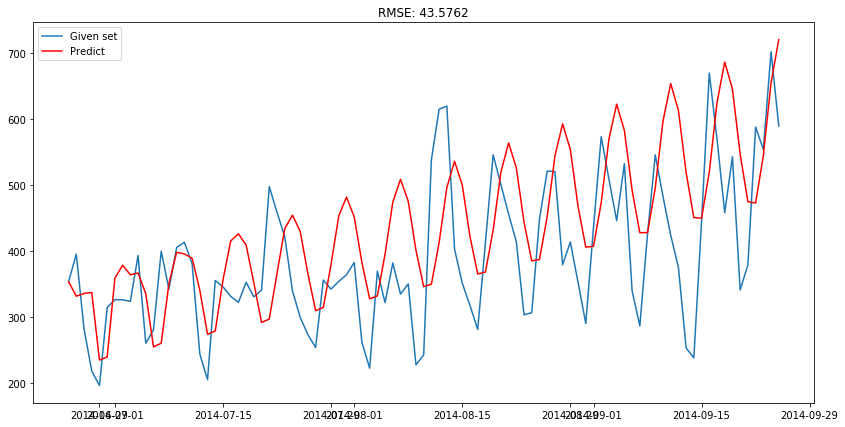

In [165]:
ARIMA_predict_diff=results_ARIMA.predict(start="2014-06-25", end="2014-09-25")
check_prediction_diff(ARIMA_predict_diff, valid)

In [283]:
test.tail();test.describe()

,ID,year,month,day,hour
count,213.000000,213.000000,213.000000,213.000000,213.0
mean,20843.500000,2014.544601,6.295775,15.708920,11.5
std,1479.167333,0.499180,4.340662,8.795891,0.0
min,18299.500000,2014.000000,1.000000,1.000000,11.5
25%,19571.500000,2014.000000,2.000000,8.000000,11.5
50%,20843.500000,2015.000000,4.000000,16.000000,11.5
75%,22115.500000,2015.000000,11.000000,23.000000,11.5
max,23387.500000,2015.000000,12.000000,31.000000,11.5


In [284]:
train_log.tail();valid.describe()

,Count,year,month,day,hour,day_of_week,weekend
count,93.000000,93.0,93.000000,93.000000,93.0,93.000000,93.00000
mean,389.295699,2014.0,7.806452,15.935484,11.5,2.989247,0.27957
std,111.069178,0.0,0.911974,8.905063,0.0,1.991802,0.45122
min,196.250000,2014.0,6.000000,1.000000,11.5,0.000000,0.00000
25%,321.833333,2014.0,7.000000,8.000000,11.5,1.000000,0.00000
50%,364.166667,2014.0,8.000000,16.000000,11.5,3.000000,0.00000
75%,448.500000,2014.0,9.000000,24.000000,11.5,5.000000,1.00000
max,702.333333,2014.0,9.000000,31.000000,11.5,6.000000,1.00000


In [287]:
ARIMA_predict_diff=results_ARIMA.predict(start="2014-09-26", end="2014-011-26")

ValueError: could not convert string to Timestamp

In [286]:
.index.is_unique

True

In [ ]:
check_prediction_diff(ARIMA_predict_diff, test)

In [166]:
ARIMA_predict_diff= ARIMA_predict_diff.cumsum().shift().fillna(0)
ARIMA_predict_base = pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index)
ARIMA_predict_log = ARIMA_predict_base.add(ARIMA_predict_diff,fill_value=0)
ARIMA_predict = np.exp(ARIMA_predict_log)

In [167]:
ARIMA_predict.head()

Datetime
2014-06-25    353.666667
2014-06-26    331.599260
2014-06-27    335.791196
2014-06-28    337.407491
2014-06-29    234.869591
Freq: D, dtype: float64

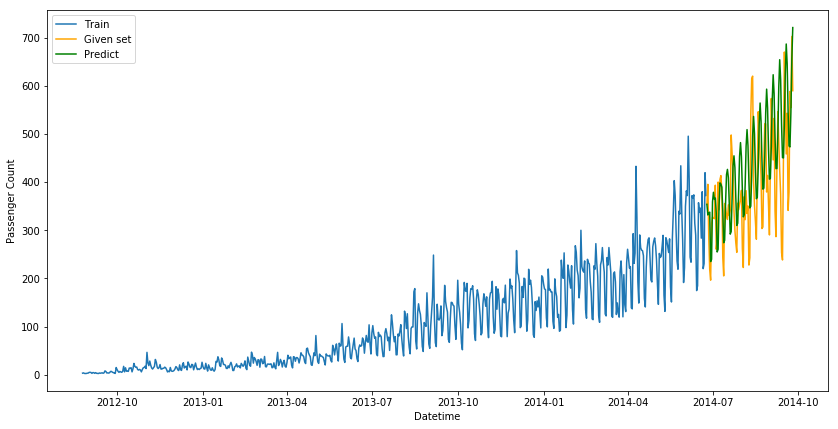

In [168]:
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], color = 'orange', label = "Given set")
plt.plot(ARIMA_predict, color = 'green', label = "Predict")
plt.xlabel("Datetime")
plt.ylabel("Passenger Count")
plt.legend(loc="best")
plt.show()

In [169]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(valid.Count, ARIMA_predict))
rms

112.47344170743204

### Predicting using ARIMA for Test dataset  

In [267]:
model_fit = sm.tsa.ARIMA(train.Count, order=(1,0,4)).fit()
predict_test = model_fit.forecast(1)
#plt.plot(train.Count.dropna(),  label='original') 
#plt.plot(model_fit.fittedvalues, color='red', label='predicted') 
#plt.legend(loc='best') 
#plt.title('RMSE: %.4f'% (np.sqrt(np.dot(model_fit.fittedvalues, train['Count']))/train.shape[0]))
#plt.show()
predict_test

(array([472.00109483]),
 array([43.0022591]),
 array([[387.71821575, 556.28397392]]))

In [245]:
test.head()

,ID,year,month,day,hour
Datetime,,,,,
2014-09-26,18299.5,2014.0,9.0,26.0,11.5
2014-09-27,18323.5,2014.0,9.0,27.0,11.5
2014-09-28,18347.5,2014.0,9.0,28.0,11.5
2014-09-29,18371.5,2014.0,9.0,29.0,11.5
2014-09-30,18395.5,2014.0,9.0,30.0,11.5


## Forecasting the Time Series using  SARIMAX 

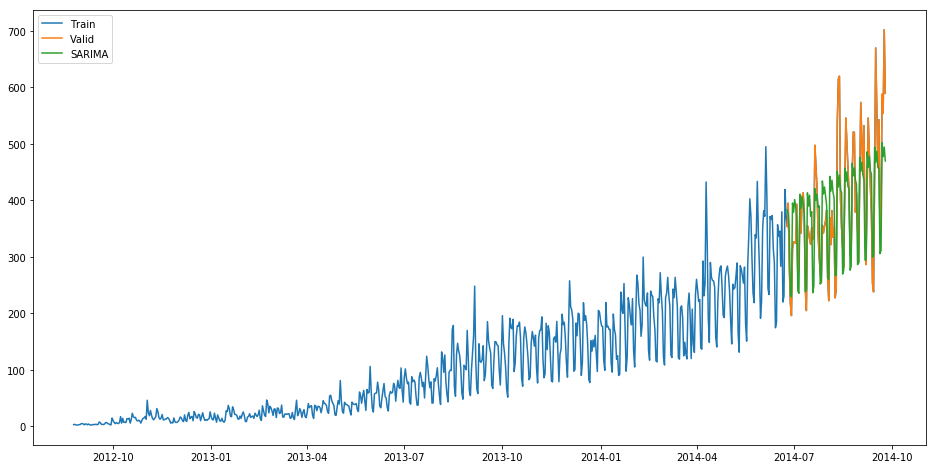

In [252]:
import statsmodels.api as sm
y_hat_avg = valid.copy() 
fit1 = sm.tsa.statespace.SARIMAX(train.Count, order=(2, 1, 4),seasonal_order=(4,2,1,7)).fit() 
y_hat_avg['SARIMA'] = fit1.predict(start="2014-6-25", end="2014-9-25", dynamic=True) 
plt.figure(figsize=(16,8)) 
plt.plot( train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()

In [253]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SARIMA))
rms

68.75826214152524

In [262]:
predict=fit1.forecast(len(test))
fit1

In [ ]:
test['prediction']=predict
test.head()

In [ ]:
# Calculating the hourly ratio of count 
train_original['ratio']=train_original['Count']/train_original['Count'].sum() 

In [ ]:
# Grouping the hourly ratio 
temp=train_original.groupby(['hour'])['ratio'].sum() 

In [ ]:
# Groupby to csv format 
pd.DataFrame(temp, columns=['hour','ratio']).to_csv('GROUPby.csv') 

In [ ]:
temp2=pd.read_csv("GROUPby.csv") 
temp2=temp2.drop('hour.1',1)
temp2.head()

In [ ]:
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left') 
merge['hour']=merge['hour_y'] 
merge=merge.drop(['year', 'month', 'Datetime','hour_x','hour_y'], axis=1) 
# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='hour', how='left') 
prediction.head()

In [ ]:
# Converting the ratio to the original scale 
prediction['Count']=prediction['prediction']*prediction['ratio']*24 
prediction['ID']=prediction['ID_y']
prediction.head()

In [ ]:
prediction2 = prediction.drop(['ID_x', 'day', 'ID_y','prediction','hour', 'ratio'],axis=1) 
prediction2.index = prediction['ID']
prediction2 = prediction2.drop(['ID'], axis=1)
prediction2.head()

In [ ]:
#submission=prediction.drop(['ID_x', 'day', 'ID_y','prediction','hour', 'ratio'],axis=1) 
submission = prediction2
submission.head()

In [ ]:
# Converting the final submission to csv format 
pd.DataFrame(submission, columns=['Count']).to_csv('SARIMAX.csv')